In [ ]:
# Author: Chad Lohrli 
# Date: December 24,2017
# Discription: Classifying MNIST w/ Feed-Forward Neural Network
# Framework: Tensorflow

In [2]:
#Libraries
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
%matplotlib inline

In [1]:
#Load Data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#preprare smaller dataset of 1000 samples from each class (10) => 10k samples
import numpy as np
xtrain = mnist.train.images
ytrain = mnist.train.labels

counter = np.array([0,0,0,0,0,0,0,0,0,0])

xtrain10k = []
ytrain10k = []

i=0
while(np.sum(counter) < 10000):
    l = np.argmax(ytrain[i])
    if(counter[l] < 1000):
        counter[l] += 1
        xtrain10k.append(xtrain[i])
        ytrain10k.append(ytrain[i])
    i += 1
    
xtrain10k = np.asarray(xtrain10k)
ytrain10k = np.asarray(ytrain10k)

In [7]:
# Model [2 layer network]

def next_batch(batch_size, x, y):
    np.random.seed(random.randint(1,1000)) 
    idx = np.arange(0 , len(x))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    xb = [x[i] for i in idx]
    yb = [y[i] for i in idx]

    return np.asarray(xb), np.asarray(yb)

def init_params(m,h,n):
    initializer = tf.contrib.layers.xavier_initializer(seed = 1)                                               
    w1 = tf.Variable(initializer([m,h]))
    #w1 = tf.get_variable("w1", [m,h], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.Variable(tf.zeros([h]))
    #w2 = tf.get_variable("w2", [h,n], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    w2 = tf.Variable(initializer([h,n]))
    b2 = tf.Variable(tf.zeros([n]))

    params = {"w1":w1,"w2":w2,"b1":b1,"b2":b2}
    return params
    

def forward(x,params):
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']
    
    layer_1 = tf.nn.relu(tf.matmul(x,w1) + b1)
    logits =  tf.matmul(layer_1, w2) + b2
    return logits

def calculate_cost(logits,y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
    return cost


def nn_model(xtrain,ytrain,xtest,ytest,hidden,epochs,batch_size,rate,custom_data=False):
   
    tf.set_random_seed(1)
    #ops.reset_default_graph() #run model without resetting variables
    
    #Parameters
    train_size = xtrain.shape[0] #training examples
    m = 784 #image size
    n = 10 #label size
    h = hidden #hidden units 
    seed = 1 #random seed
    costs = [] #accumulate costs
    train_acc = [] #accumulate train accuracy
    test_acc = [] # accumulate test accuracy

    
    x = tf.placeholder(tf.float32,[None, m])
    y = tf.placeholder(tf.float32,[None,n])

    params = init_params(m,h,n)

    logits = forward(x,params)
    cost = calculate_cost(logits,y)
    optimizer = tf.train.AdamOptimizer(learning_rate=rate).minimize(cost)
    
    predict = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(predict,"float"))
    
    init = tf.global_variables_initializer()
    
    #start session, this is where training happens
    with tf.Session() as sess:
        sess.run(init)
    
        for epoch in xrange(epochs+1):
            ecost = 0.
            batch_num = int(train_size / batch_size)
            for i in range(batch_num):
                xb = 0;
                yb = 0;
                if custom_data:
                    xb, yb = next_batch(batch_size,xtrain,ytrain)
                else:
                    xb, yb = mnist.train.next_batch(batch_size)
                    
                _, batch_cost = sess.run([optimizer,cost], feed_dict={x:xb,y:yb})
                ecost += batch_cost / batch_num
            
            if epoch % 5 == 0:
                print("epoch %i | cost %f" % (epoch,ecost))
                
            costs.append(ecost)
            train_acc.append(accuracy.eval({x:xtrain,y:ytrain}))
            test_acc.append(accuracy.eval({x:xtest,y:ytest}))
      
        params = sess.run(params)
        print("Final Train Accuracy:", accuracy.eval({x:xtrain,y:ytrain}))
        print("Final Test Accuracy:", accuracy.eval({x:xtest,y:ytest}))
    
    return train_acc,test_acc,params,costs


#Data
xtrain = mnist.train.images
ytrain = mnist.train.labels
xtest = mnist.test.images
ytest = mnist.test.labels


#HyperParameters
batch_size = 128
epochs = 20
rate = 0.01   
hidden = 300

In [8]:
#Run Model On Original Data
train_acc,test_acc,params, costs = nn_model(xtrain,ytrain,xtest,ytest,hidden,epochs,batch_size,rate)

epoch 0 | cost 0.215078
epoch 5 | cost 0.065034
epoch 10 | cost 0.047263
epoch 15 | cost 0.044497
epoch 20 | cost 0.040451
('Final Train Accuracy:', 0.9939273)
('Final Test Accuracy:', 0.97509998)


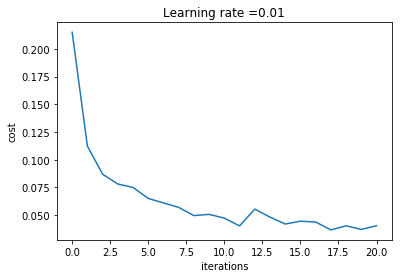

In [9]:
#Plot loss for original dataset
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(rate))
plt.show()

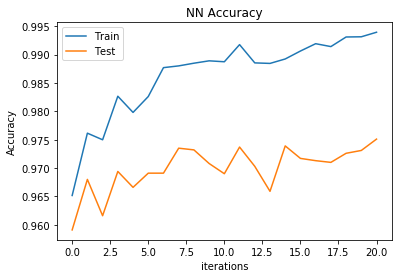

In [10]:
#Plot test and train accuracy on original set
plt.plot(train_acc,label="Train")
plt.plot(test_acc,label="Test")
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title("NN Accuracy")
plt.legend()

In [11]:
#Run Model On 10k Set
train_acc_10k,test_acc_10k,params_10k, costs_10k = nn_model(xtrain10k,ytrain10k,xtest,ytest,hidden,epochs,batch_size,rate,True)

epoch 0 | cost 0.396991
epoch 5 | cost 0.048300
epoch 10 | cost 0.026225
epoch 15 | cost 0.025650
epoch 20 | cost 0.041150
('Final Train Accuracy:', 0.98809999)
('Final Test Accuracy:', 0.95130002)


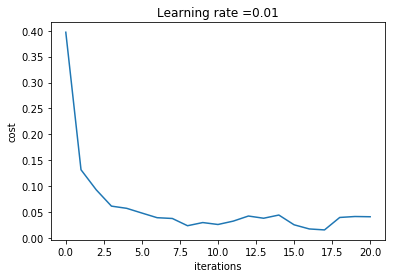

In [12]:
#Plot loss for 10k dataset
plt.plot(np.squeeze(costs_10k))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(rate))
plt.show()

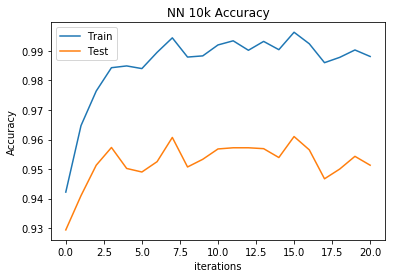

In [13]:
#Plot test and train accuracy for 10k dataset
plt.plot(train_acc_10k,label="Train")
plt.plot(test_acc_10k,label="Test")
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title("NN 10k Accuracy")
plt.legend()

In [14]:
# Analysis: We obtain slightly higher accuracies with more data

6
[6]


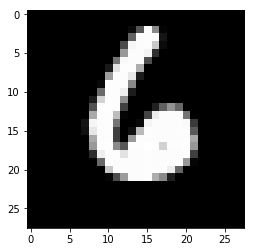

In [49]:
#Test on an image for fun
xtrain = mnist.train.images
ytrain = mnist.train.labels

index = random.randint(1,len(ytest))
print(np.argmax(ytest[index]))

image = xtest[index].reshape([28,28])
t = xtest[index].reshape(28*28,1).T
sess = tf.Session()

predict = tf.argmax(forward(t,params),1)
print(sess.run(predict))

plt.gray()
plt.imshow(image)